# RDS Lab 9: Explaining models with SHAP

This lab is based on Scott Lundberg's [SHAP Demo](https://github.com/slundberg/shap/blob/master/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.ipynb). We'll be explaining a sentiment analysis model using SHAP, or "SHapley Additive exPlanations."

You can find the original paper about the SHAP package [here](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf). 


In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import xgboost
shap.initjs()

## Step 1: Load and prep the IMDB dataset

The dataset we use is the classic IMDB dataset from [this paper](https://www.aclweb.org/anthology/P11-1015/).  The data consists of movie reviews, and our task is to predict whether the review is positive or negative. 

In [2]:
# Load the data
corpus,y = shap.datasets.imdb()

# Take a look at the first example
corpus[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

Note that this data is literally just text. We'll need to process it somehow before feeding it into a model. 

In [3]:
# Split into train and test sets
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

The most intuitive way to transform text into numbers would be to simply count up how many times each word occurs in each text. We could represent each document as a vector of word counts, where each element of the vector corresponds to one word in our vocabulary.

For example, consider a corpus of the following documents:
- "The rat ate the pizza."
- "The pizza is delicious."
- "The cats are fluffy."

We have 9 words in the vocabulary: ['ate', 'are', 'cats', 'delicious', 'fluffy', 'is', 'pizza', 'rat', 'the']. We could represent the first document as [1, 0, 0, 0, 0, 0, 1, 1, 2]. 

However, this method has some shortcomings. **Can you think of any?**

Instead, we're going to use the [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from sklearn. TF-IDF stands for "term frequency - inverse document frequency." In its simplest form, for each word (term) $i$ in each document $j$, we calculate the TF-DF value $w_{i,j}$ as:

<img src="https://miro.medium.com/max/638/1*Uucq42G4ntPGJKzI84b3aA.png" />

We represent each document as a vector of the TF-IDF values for each word. Using the example above, the first document would be represented as [0.47, 0, 0, 0, 0, 0, 0.17, 0.47, 0].

The vectorizor will make this transformation for us. **Think about what we are "fitting" on the training data in the code below.**

In [4]:
# Fit vectorizer on training data, then transform both the training and test data
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

## Step 2: Fit a gradient-boosted decision tree model

In [16]:
model = sklearn.linear_model.LogisticRegression(penalty="l1", C=0.1)
model.fit(X_train, y_train)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
# Evaluate our classifier's performance
sklearn.metrics.accuracy_score(model.predict(X_test), y_test)

0.791

## Step 3: Explain the model using SHAP

Like in LIME, we need to create an explainer object in SHAP. However, the type of SHAP explainer we use will be determined by the sort of model that we trained. Because we trained an xgboost model, which is from sklearn.linear_model, we'll want to use a LinearExplainer. See other options [here](https://shap.readthedocs.io/en/latest/#). 

In [18]:
# Initialize the explainer
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="independent")
# Apply it to the test data
shap_values = explainer.shap_values(X_test)

The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


We can use summary_plot to summarize the most important features. **What are we looking at in this graph?**
- Each dot is an example in the test set.
- The color of each dot tells us the value of the feature -- that is, the TF-IDF value for that word in that document.
- The SHAP value tells us the contribution of that feature to each prediction.

Based on this information, 
- What order are these words in? What determines which words we're seeing in this visualization?
- Why are the dots for "and" so tightly clustered?
A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

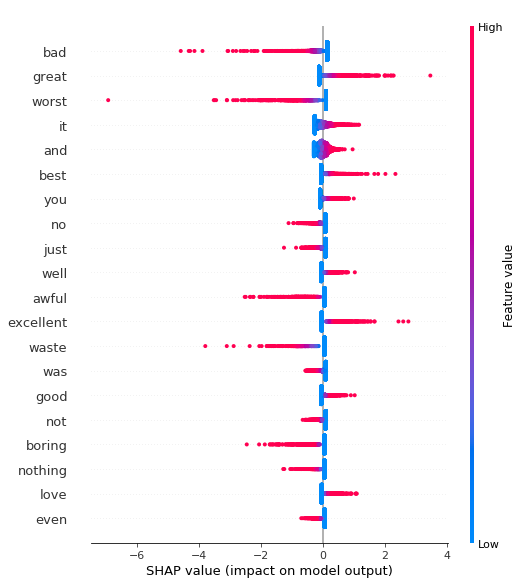

In [109]:
X_test_array = X_test.toarray() # We need to provide the data in dense format, not sparse
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

Dependence plots let us zoom in on a single feature and see how its 1) importance and 2) relationship to the outcome vary across its range.


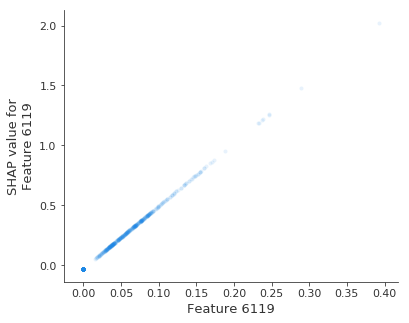

In [125]:
shap.dependence_plot(vectorizer.get_feature_names().index("fun"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

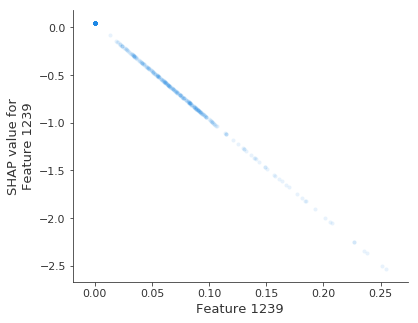

In [121]:
shap.dependence_plot(vectorizer.get_feature_names().index("awful"), shap_values, X_test_array, alpha=0.1, interaction_index=None)

We can also color the plot by the relationship between two features. For example, we might expect the word "enjoyable" to have a lower SHAP value in texts where we also see the word "not"...

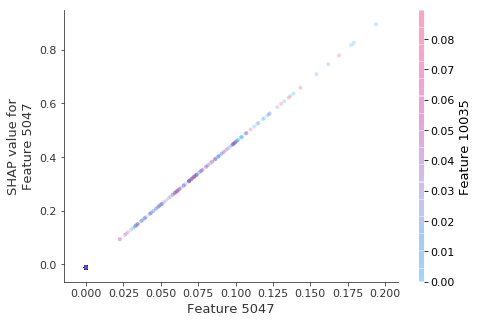

In [127]:
shap.dependence_plot(vectorizer.get_feature_names().index("enjoyable"), shap_values, X_test_array, alpha=0.2, 
                     interaction_index=vectorizer.get_feature_names().index("not"))

...but this turns out not to be the case because we're using a linear model.

These plots aren't super useful for this particular application, but they *are* important for cases where we suspect a nonliner relationship between a featuer and the outcome. See the results for age in the adult dataset [here](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html).

Next, let's look at the explanation for a single review. 

In [115]:
ind = 5
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

Negative Review:
A chemical spill is turning people into zombies. It's up to two doctor's to survive the epidemic. It's an Andreas Schnaas film so you know what the par for the course will be. Bad acting, horribly awful special effects, and no budget to speak of. The dubbing is ridiculous with a capital R and the saddest thing is that I feel compelled to write one word about this piece of excrement, much less the ten lines mandatory because of the guidelines placed on me by IMDb. My original review of merely one word: Crap wouldn't fly so I have to revise it and go more in to how bad it is. But I don't know if I can, so.. wait I think I may have enough words, or lines rather to make this review pass. Which is cool, I guess. So in summation: This movie sucks balls, don't watch it.<br /><br />My Grade: F



Try looking at another review

In [95]:
# Your code here